   ## Import libraries

In [1]:
import sys
import os

# Import local libs
module_path = os.path.abspath(os.path.join('.', 'libs'))
if module_path not in sys.path:
    sys.path.append(module_path)
from s3utils import *
from rooftop import *

/Users/colinbrust/projects/rooftop-index/venv/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


   ## 1. Set variables and parameters

In [2]:
# Paths and file names
bucket_name = 'roof-index'
main_dir = 'austin/geospatial/'  # Main directory to read and write from in S3 bucket.
dsm_fname = 'austin_dsm.tif'
hfdem_fname = 'austin_dem.tif'
bldgs_fname = 'bldg_footprint.zip'
bldgs_id = 'fid'  # Name of the unique id used in the buildings shapefile 
slope_fname = 'test_slope.tif'  # Does not exist. This is the name of the file to be written.
height_fname = 'test_height.tif'  # Does not exist. This is the name of the file to be written.
flat_area_fname = 'test_flat_area_bldgs.zip'  # Does not exist. This the name of the file to be written.

# Parameters
pitch_slope_threshold = 11  # Max. slope (degrees) to which we consider roof to be flat.
pitch_area_threshold = 9  # Min. percentage of flat area on a roof to be classified as flat.
fa_slope_threshold = 45  # Max. value of slope for flat area disaggregation
fa_area_threshold = 93.903  # Min. area in m^2 for flat area disaggregation


   ## 3. Instantiate S3 and Rooftop objects

In [3]:
S3 = S3Helper(bucket_name)
Rooftop = RooftopProc(S3, main_dir, dsm_fname, hfdem_fname, bldgs_fname, bldgs_id)

   ## 4. Create slope and height arrays and upload to S3 as geotiffs

In [4]:
slope_arr = Rooftop.create_slope_arr(slope_fname) 
height_arr = Rooftop.create_height_arr(height_fname)

test_slope.tif has been successfully written to your S3 bucket.
test_height.tif has been successfully written to your S3 bucket.


   ## 5. Filter out pitched roofs from bldgs dataframe

In [5]:
flat_bldgs = Rooftop.pitched_roof_filter(pitch_area_threshold, pitch_area_threshold)

/Users/colinbrust/projects/rooftop-index/venv/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:1097: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


   ## 6. Disaggregate building footprints into flat areas

In [6]:
disagg_bldgs = Rooftop.flat_area_disaggregator(flat_bldgs, fa_slope_threshold, fa_area_threshold, flat_area_fname)

Creating polygons from raster data. Hang on, this may take a bit.
test_flat_area_bldgs.zip has been successfully written to your S3 bucket.


   ## 7. Add rooftop features
 Features list below can include:

 - 'average_slope'
 - 'height'
 - 'parapet'
 - 'closeness_to_points'
 - 'volume_on_roof'

In [25]:
features = ['average_slope', 'height', 'parapet', 'volume_on_roof']
ctp_paths = ['test_greenspaces.zip', 'test_groceries.zip']
full_features = Rooftop.feature_builder(disagg_bldgs, features, ctp_paths=ctp_paths)

Adding average slope feature now.
Adding median height feature now.
Adding parapet feature now.
Adding volume on roof feature now.


   ## 8. Create index

<ipython-input-33-6639aef0979b>:10: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  mcda.to_file('/Users/colinbrust/Desktop/austin_index.shp')


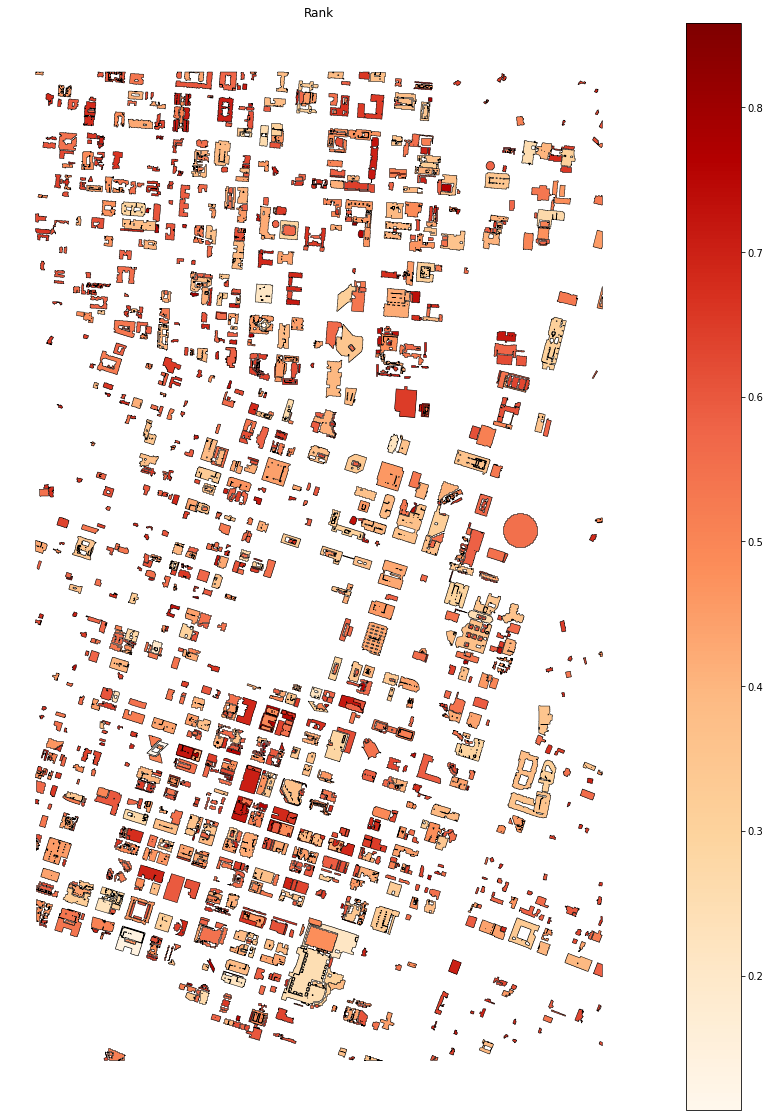

In [33]:
import matplotlib.pyplot as plt

wts = [(1/7) * 2, 1/7, (1/7) / 2, (1/7) / 2, (1/7) / 2, (1/7) / 2, (1/7) * 2]
mcda = Rooftop.index_builder(full_features, None)
mcda = gpd.GeoDataFrame(mcda)
ax = mcda.plot(column="vulnerability", cmap='OrRd', legend=True, figsize=[20,20], edgecolor='k', linewidth=0.5)
ax.set_title('Rank')
ax.axis('off')

mcda.to_file('/Users/colinbrust/Desktop/austin_index.shp')

(1/7) * 2